In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e4/sample_submission.csv
/kaggle/input/playground-series-s5e4/train.csv
/kaggle/input/playground-series-s5e4/test.csv


In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [18]:
train_data = pd.read_csv('/kaggle/input/playground-series-s5e4/train.csv')
test_data = pd.read_csv('/kaggle/input/playground-series-s5e4/test.csv')

In [19]:
train_data.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [20]:
train_data.shape, test_data.shape

((750000, 12), (250000, 11))

In [21]:
train_data.isnull().sum()

id                                  0
Podcast_Name                        0
Episode_Title                       0
Episode_Length_minutes          87093
Genre                               0
Host_Popularity_percentage          0
Publication_Day                     0
Publication_Time                    0
Guest_Popularity_percentage    146030
Number_of_Ads                       1
Episode_Sentiment                   0
Listening_Time_minutes              0
dtype: int64

In [22]:
test_data.isnull().sum()

id                                 0
Podcast_Name                       0
Episode_Title                      0
Episode_Length_minutes         28736
Genre                              0
Host_Popularity_percentage         0
Publication_Day                    0
Publication_Time                   0
Guest_Popularity_percentage    48832
Number_of_Ads                      0
Episode_Sentiment                  0
dtype: int64

In [23]:
test_data.dtypes

id                               int64
Podcast_Name                    object
Episode_Title                   object
Episode_Length_minutes         float64
Genre                           object
Host_Popularity_percentage     float64
Publication_Day                 object
Publication_Time                object
Guest_Popularity_percentage    float64
Number_of_Ads                  float64
Episode_Sentiment               object
dtype: object

In [24]:
numeric_only = train_data.select_dtypes(include=['int64','float64']).columns.drop(['id', 'Listening_Time_minutes'])
train_data[numeric_only].corr()

,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads
Episode_Length_minutes,1.000000,0.023596,-0.009704,-0.054953
Host_Popularity_percentage,0.023596,1.000000,0.022431,-0.017896
Guest_Popularity_percentage,-0.009704,0.022431,1.000000,0.007933
Number_of_Ads,-0.054953,-0.017896,0.007933,1.000000


In [25]:
train_data[numeric_only] = train_data[numeric_only].fillna(train_data[numeric_only].median())
test_data[numeric_only] = test_data[numeric_only].fillna(test_data[numeric_only].median())

categorical_only = train_data.select_dtypes(include=['object']).columns

for col in categorical_only:
    train_data[col] = train_data[col].fillna(train_data[col].mode()[0])
    test_data[col] = test_data[col].fillna(train_data[col].mode()[0])

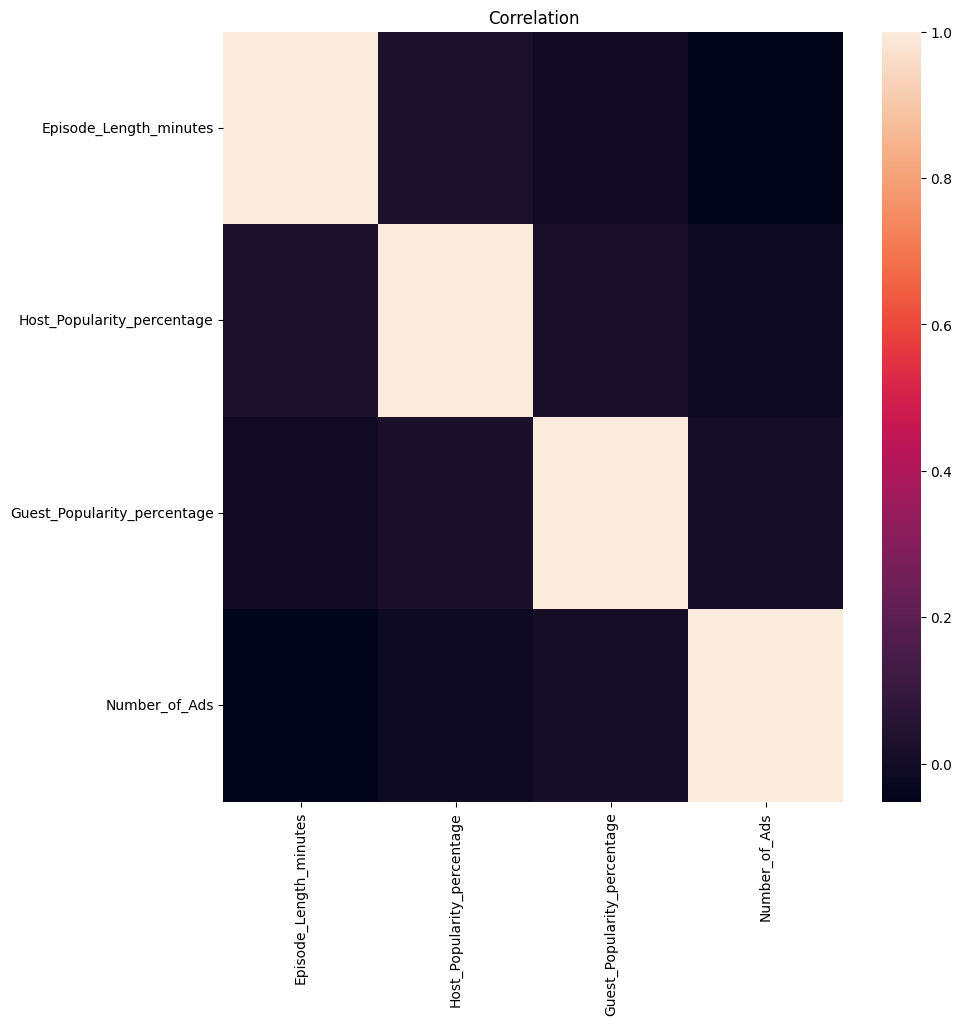

In [26]:
plt.figure(figsize=(10,10))
t_corr = train_data[numeric_only].corr()
sns.heatmap(t_corr)
plt.title('Correlation')
plt.show()

In [27]:
for col in categorical_only:
    le = LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col])
    test_data[col] = le.transform(test_data[col])

In [28]:
X = train_data.drop(['id', 'Listening_Time_minutes'],axis=1)
y = train_data['Listening_Time_minutes']

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)

model.fit(X_train, y_train)
preds = model.predict(X_test)

mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
rmse

13.08968798736232

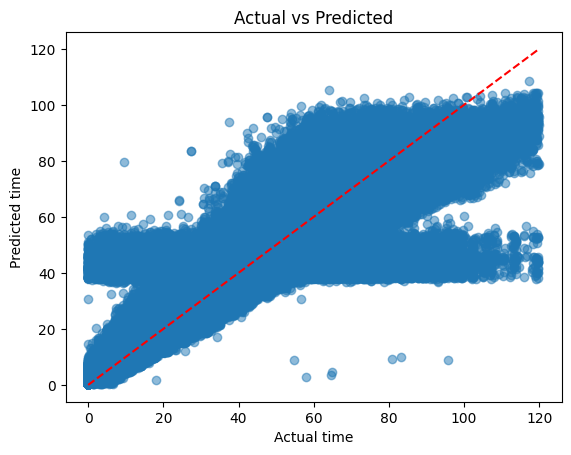

In [31]:
plt.scatter(y_test, preds, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual time')
plt.ylabel('Predicted time')
plt.title('Actual vs Predicted')
plt.show()

In [32]:
final_predict = model.predict(test_data.drop('id', axis=1))

id_test = pd.read_csv('/kaggle/input/playground-series-s5e4/test.csv')['id']

submission = pd.DataFrame(
    {
        'id': id_test,
        'Listening_Time_minutes': final_predict
    }
)
submission.to_csv('submission.csv', index=False)
print("Succesful")

Succesful


In [33]:
submission

,id,Listening_Time_minutes
0,750000,56.791268
1,750001,17.705760
2,750002,49.730454
3,750003,79.915857
4,750004,47.788304
...,...,...
249995,999995,11.954137
249996,999996,57.778206
249997,999997,7.503549
249998,999998,72.859908
